## Import des librairies

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score
from pathlib import Path

In [25]:
K.clear_session()

In [26]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Configuration et Prétraitement des Données

In [27]:
IMG_SIZE = (224, 224)
# BATCH_SIZE = 32
# BATCH_SIZE = 8
BATCH_SIZE = 4
EPOCHS = 30 
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

AUTOTUNE = tf.data.AUTOTUNE

In [28]:
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [29]:
train_dataset = image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
)
train_dataset = preprocess_dataset(train_dataset)

validation_dataset = image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
)
validation_dataset = preprocess_dataset(validation_dataset)

test_dataset = image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
)
test_dataset = preprocess_dataset(test_dataset)

Found 12485 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


## Création du modèle

In [30]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajout de couches au-dessus du modèle de base
x = base_model.output
x = Flatten(name='new_flatten')(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
classifieur = Dense(3, activation='softmax')(x)

new_model = Model(inputs=base_model.input, outputs=classifieur)

In [31]:
# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,206,083 (80.89 MB)

 Trainable params: 6,490,371 (24.76 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

## Entraînement et Évaluation

In [32]:
# Callbacks pour l'entraînement
es = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=10,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

In [33]:
# Entraînement initial
history = new_model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=EPOCHS, 
    callbacks=[es, reduce_lr],
    shuffle=True
)

Epoch 1/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 104s 30ms/step - accuracy: 0.5695 - loss: 6.5889 - recall: 0.5433 - val_accuracy: 0.5972 - val_loss: 4.8119 - val_recall: 0.5694 - learning_rate: 1.0000e-04
Epoch 2/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.6545 - loss: 4.4871 - recall: 0.6310 - val_accuracy: 0.5694 - val_loss: 3.5654 - val_recall: 0.5556 - learning_rate: 1.0000e-04
Epoch 3/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - accuracy: 0.6690 - loss: 3.2699 - recall: 0.6389 - val_accuracy: 0.6007 - val_loss: 2.7081 - val_recall: 0.5903 - learning_rate: 1.0000e-04
Epoch 4/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.6963 - loss: 2.4454 - recall: 0.6674 - val_accuracy: 0.6146 - val_loss: 2.1913 - val_recall: 0.6042 - learning_rate: 1.0000e-04
Epoch 5/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.7234 - loss: 1.9461 - recall: 0.6925 - val_accuracy: 0.6319 - val_loss: 1.8461 - val_recall: 0.6181 - learning_rate: 1.0000e-04
Epoch 6/3

In [34]:
# Première phase de fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [35]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [36]:
history_fine_tune_1 = new_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es, reduce_lr],
    shuffle=True
)

Epoch 1/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 137s 42ms/step - accuracy: 0.7968 - loss: 0.7549 - recall_1: 0.7765 - val_accuracy: 0.6458 - val_loss: 1.0421 - val_recall_1: 0.6389 - learning_rate: 1.0000e-05
Epoch 2/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 121s 39ms/step - accuracy: 0.8340 - loss: 0.6551 - recall_1: 0.8177 - val_accuracy: 0.6181 - val_loss: 1.0557 - val_recall_1: 0.6146 - learning_rate: 1.0000e-05
Epoch 3/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 120s 39ms/step - accuracy: 0.8169 - loss: 0.6727 - recall_1: 0.7956 - val_accuracy: 0.6354 - val_loss: 1.0282 - val_recall_1: 0.6285 - learning_rate: 1.0000e-05
Epoch 4/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 127s 41ms/step - accuracy: 0.8497 - loss: 0.5942 - recall_1: 0.8346 - val_accuracy: 0.6215 - val_loss: 1.2576 - val_recall_1: 0.6146 - learning_rate: 1.0000e-05
Epoch 5/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 127s 41ms/step - accuracy: 0.8641 - loss: 0.5471 - recall_1: 0.8523 - val_accuracy: 0.6528 - val_loss: 0.9792 - val_recall_1: 0.6424 - learning_ra

In [37]:
# Deuxième phase de fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [38]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [39]:
history_fine_tune_2 = new_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es, reduce_lr],
    shuffle=True
)

Epoch 1/30


2024-07-02 12:33:27.548435: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-02 12:33:27.746303: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3122/3122 ━━━━━━━━━━━━━━━━━━━━ 189s 59ms/step - accuracy: 0.8476 - loss: 0.6371 - recall_2: 0.8319 - val_accuracy: 0.6597 - val_loss: 0.9969 - val_recall_2: 0.6458 - learning_rate: 1.0000e-06
Epoch 2/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 181s 58ms/step - accuracy: 0.8668 - loss: 0.5926 - recall_2: 0.8512 - val_accuracy: 0.6354 - val_loss: 1.0136 - val_recall_2: 0.6319 - learning_rate: 1.0000e-06
Epoch 3/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 181s 58ms/step - accuracy: 0.8781 - loss: 0.5701 - recall_2: 0.8662 - val_accuracy: 0.6528 - val_loss: 1.0614 - val_recall_2: 0.6354 - learning_rate: 1.0000e-06
Epoch 4/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 181s 58ms/step - accuracy: 0.8870 - loss: 0.5556 - recall_2: 0.8728 - val_accuracy: 0.6528 - val_loss: 1.0489 - val_recall_2: 0.6389 - learning_rate: 1.0000e-06
Epoch 5/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 181s 58ms/step - accuracy: 0.8954 - loss: 0.5290 - recall_2: 0.8836 - val_accuracy: 0.6597 - val_loss: 1.0544 - val_recall_2: 0.6458 - learning_rate: 2.0000e

In [40]:
# Troisième phase de fine-tuning
for layer in base_model.layers:
    layer.trainable = True

In [41]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

In [42]:
history_fine_tune_3 = new_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es, reduce_lr],
    shuffle=True
)

Epoch 1/30
   1/3122 ━━━━━━━━━━━━━━━━━━━━ 12:03:35 14s/step - accuracy: 0.7500 - loss: 0.5239 - recall_3: 0.7500

I0000 00:00:1719918276.024797    6652 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_10', 164 bytes spill stores, 164 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_9', 36 bytes spill stores, 36 bytes spill loads



3122/3122 ━━━━━━━━━━━━━━━━━━━━ 304s 93ms/step - accuracy: 0.8683 - loss: 0.5960 - recall_3: 0.8522 - val_accuracy: 0.6632 - val_loss: 1.0221 - val_recall_3: 0.6458 - learning_rate: 1.0000e-07
Epoch 2/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 281s 90ms/step - accuracy: 0.8734 - loss: 0.5864 - recall_3: 0.8545 - val_accuracy: 0.6562 - val_loss: 1.0056 - val_recall_3: 0.6528 - learning_rate: 1.0000e-07
Epoch 3/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 284s 91ms/step - accuracy: 0.8648 - loss: 0.6116 - recall_3: 0.8474 - val_accuracy: 0.6458 - val_loss: 1.0456 - val_recall_3: 0.6354 - learning_rate: 1.0000e-07
Epoch 4/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 283s 91ms/step - accuracy: 0.8720 - loss: 0.5820 - recall_3: 0.8617 - val_accuracy: 0.6528 - val_loss: 1.0020 - val_recall_3: 0.6424 - learning_rate: 1.0000e-07
Epoch 5/30
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 284s 91ms/step - accuracy: 0.8775 - loss: 0.5789 - recall_3: 0.8625 - val_accuracy: 0.6458 - val_loss: 1.0300 - val_recall_3: 0.6354 - learning_rate: 1.0000e

In [43]:
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.8291 - loss: 0.7544 - recall_3: 0.8058
Loss on test dataset: 0.7532089948654175
Accuracy on test dataset: 0.8150851726531982
Recall on test dataset: 0.7944039106369019


In [44]:
new_model.save('my_new_model_finetuned.keras')

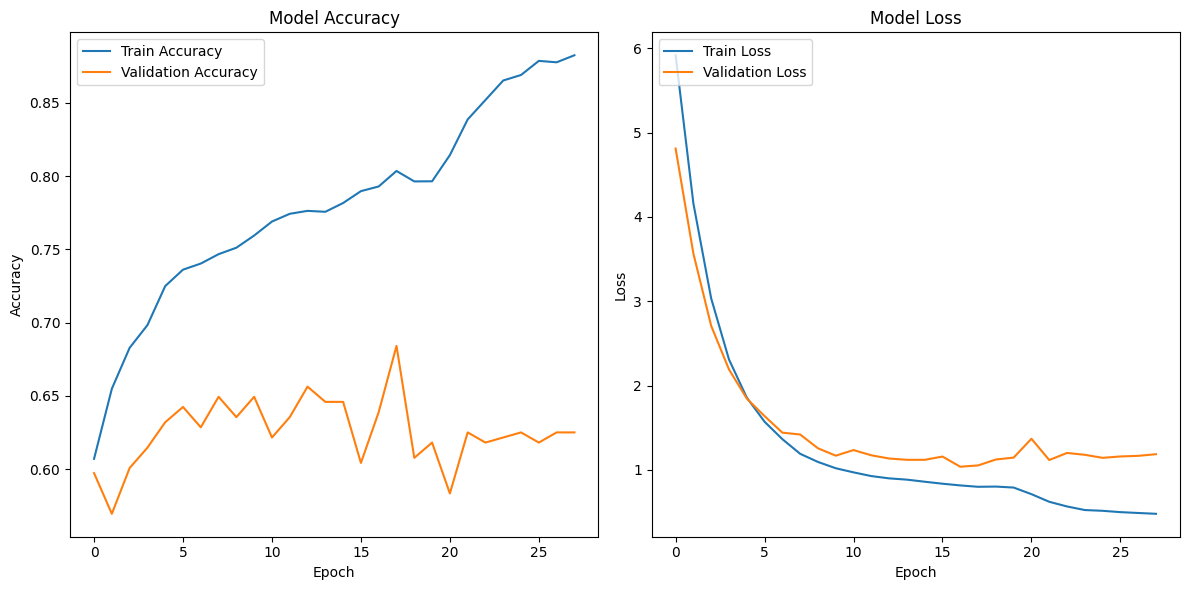

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

2024-07-02 13:52:25.052238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step


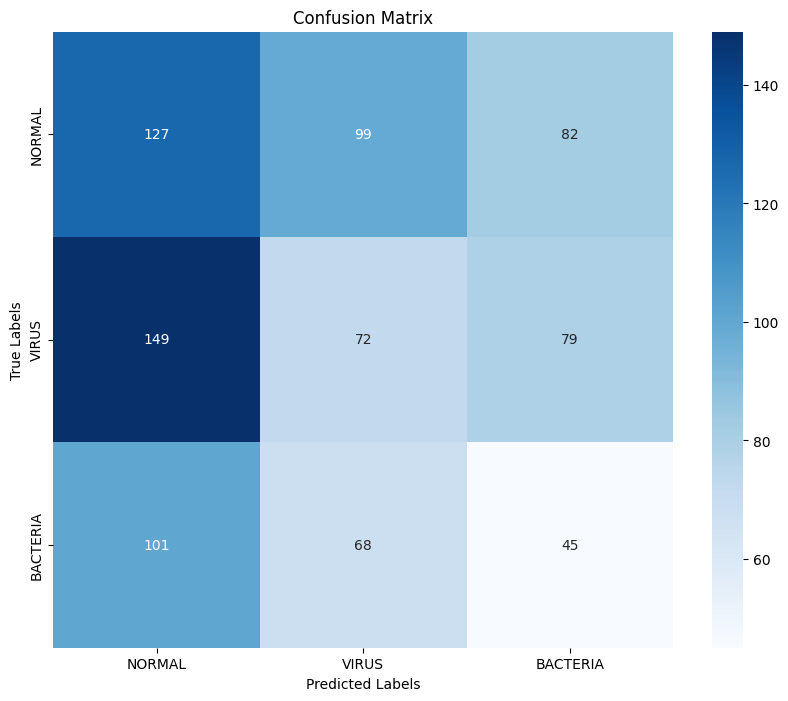

In [46]:
# Prédire les classes sur le jeu de test
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = new_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Tracer la heatmap de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()